# Clasificación binaria
Hasta ahora, solo ha creado modelos de regresión. Es decir, creaste modelos que produjeron predicciones de punto flotante, como "las casas en este vecindario cuestan N mil dólares". En este Colab, crearás y evaluarás un modelo de clasificación binaria. Es decir, crearás un modelo que responda una pregunta binaria. En este ejercicio, la pregunta binaria será: "¿Están las casas en este barrio por encima de cierto precio?"

## Objetivos de aprendizaje:

Después de hacer este Colab, sabrás cómo:

   * Convertir una pregunta de regresión en una pregunta de clasificación.
   * Modificar el umbral de clasificación y determinar cómo influye esa modificación en el modelo.
   * Experimentar con diferentes métricas de clasificación para determinar la efectividad de su modelo.

## Llame a las declaraciones de importación

El siguiente código importa los módulos necesarios.

In [1]:
#@title cargar las importaciones

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# Las siguientes líneas ajustan la granularidad de los informes.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


## Cargue los conjuntos de datos de Internet

La siguiente celda de código carga los archivos .csv separados y crea los siguientes dos pandas DataFrames:

* `train_df`, que contiene el conjunto de entrenamiento
* `test_df`, que contiene el conjunto de prueba

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # mezclamos el conjunto de entrenamiento

A diferencia de algunos de los Colab anteriores, la celda de código anterior no escalaba la etiqueta (`median_house_value`). La siguiente sección ("Normalizar valores") proporciona un enfoque alternativo.

## Normalizar valores

Al crear un modelo con varias funciones, los valores de cada función deben cubrir aproximadamente el mismo rango. Por ejemplo, si el rango de una característica abarca de 500 a 100 000 y el rango de otra característica abarca de 2 a 12, el modelo será difícil o imposible de entrenar. Por lo tanto, deberías
[normalizar](https://developers.google.com/machine-learning/glossary/#normalization) funciones en un modelo de funciones múltiples.

La siguiente celda de código normaliza los conjuntos de datos convirtiendo cada valor sin procesar (incluida la etiqueta) en su puntuación Z. Una **puntuación Z, o Z-score**  es el número de desviaciones estándar de la media para un valor bruto particular. Por ejemplo, considere una característica que tenga las siguientes características:

   * La media es 60.
   * La desviación estándar es 10.

El valor bruto 75 tendría una puntuación Z de +1,5:

```
   Puntuación Z = (75 - 60) / 10 = +1,5
```

El valor bruto 38 tendría una puntuación Z de -2,2:

```
   Puntuación Z = (38 - 60) / 10 = -2.2
```

#### **Cómo calculamos el Z-score**

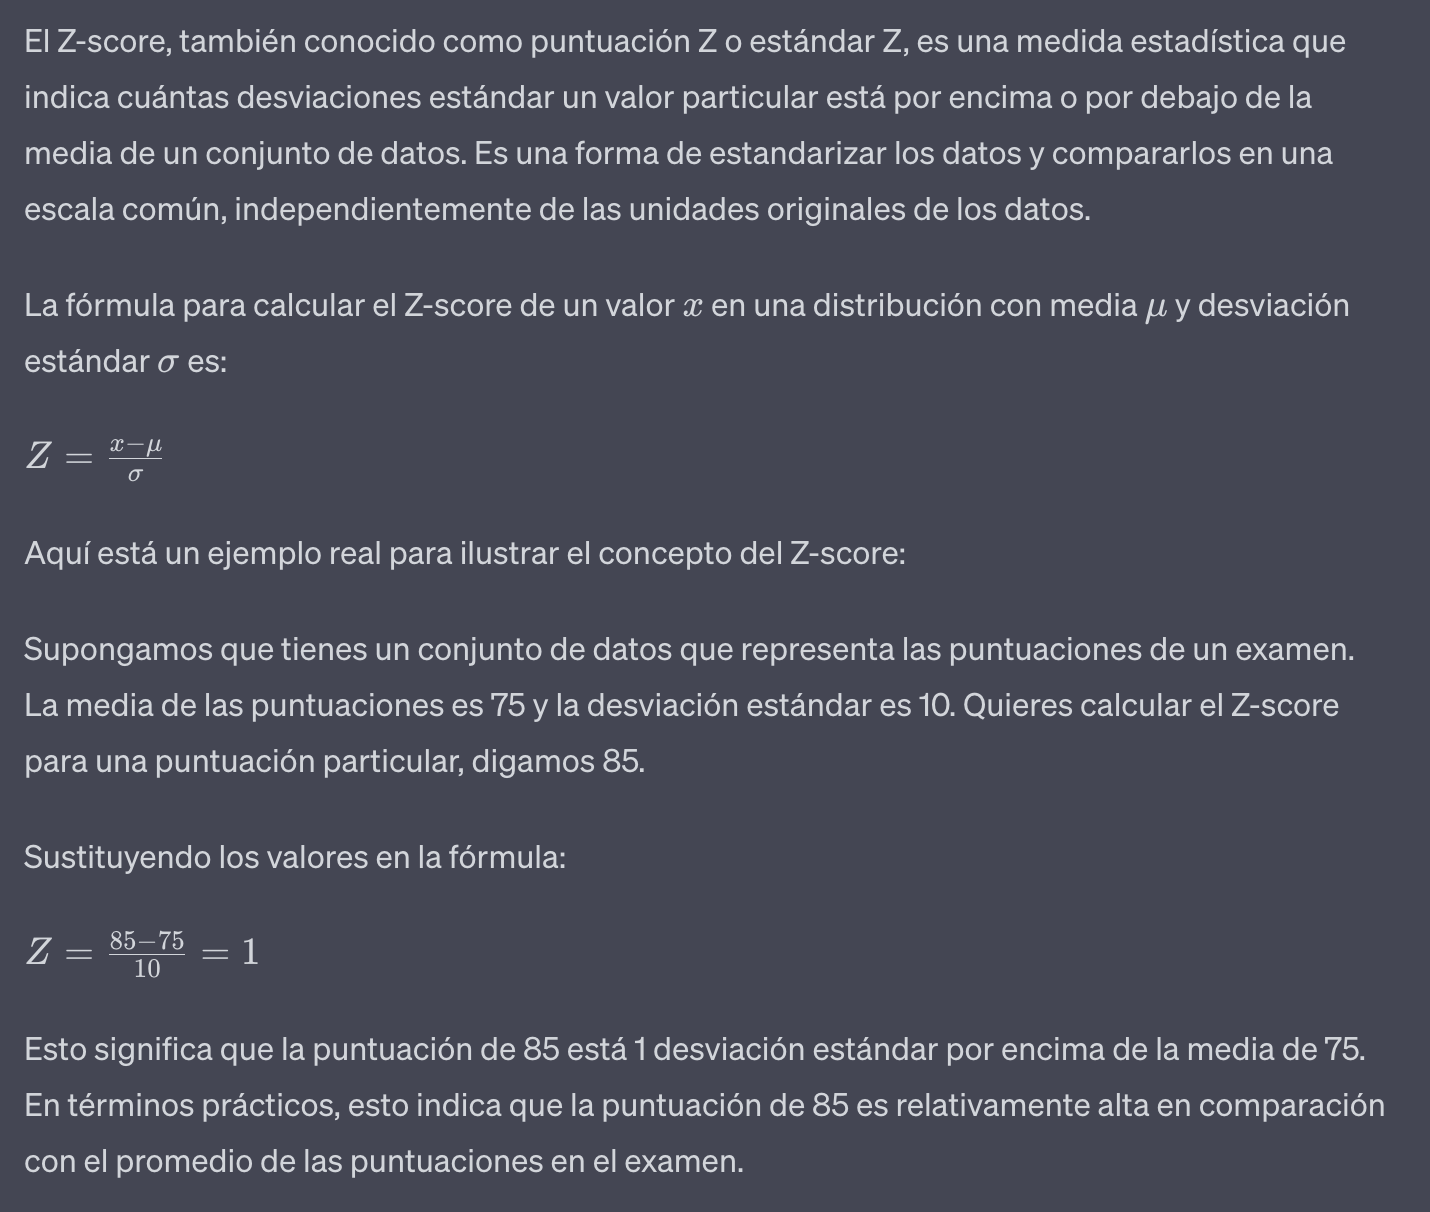

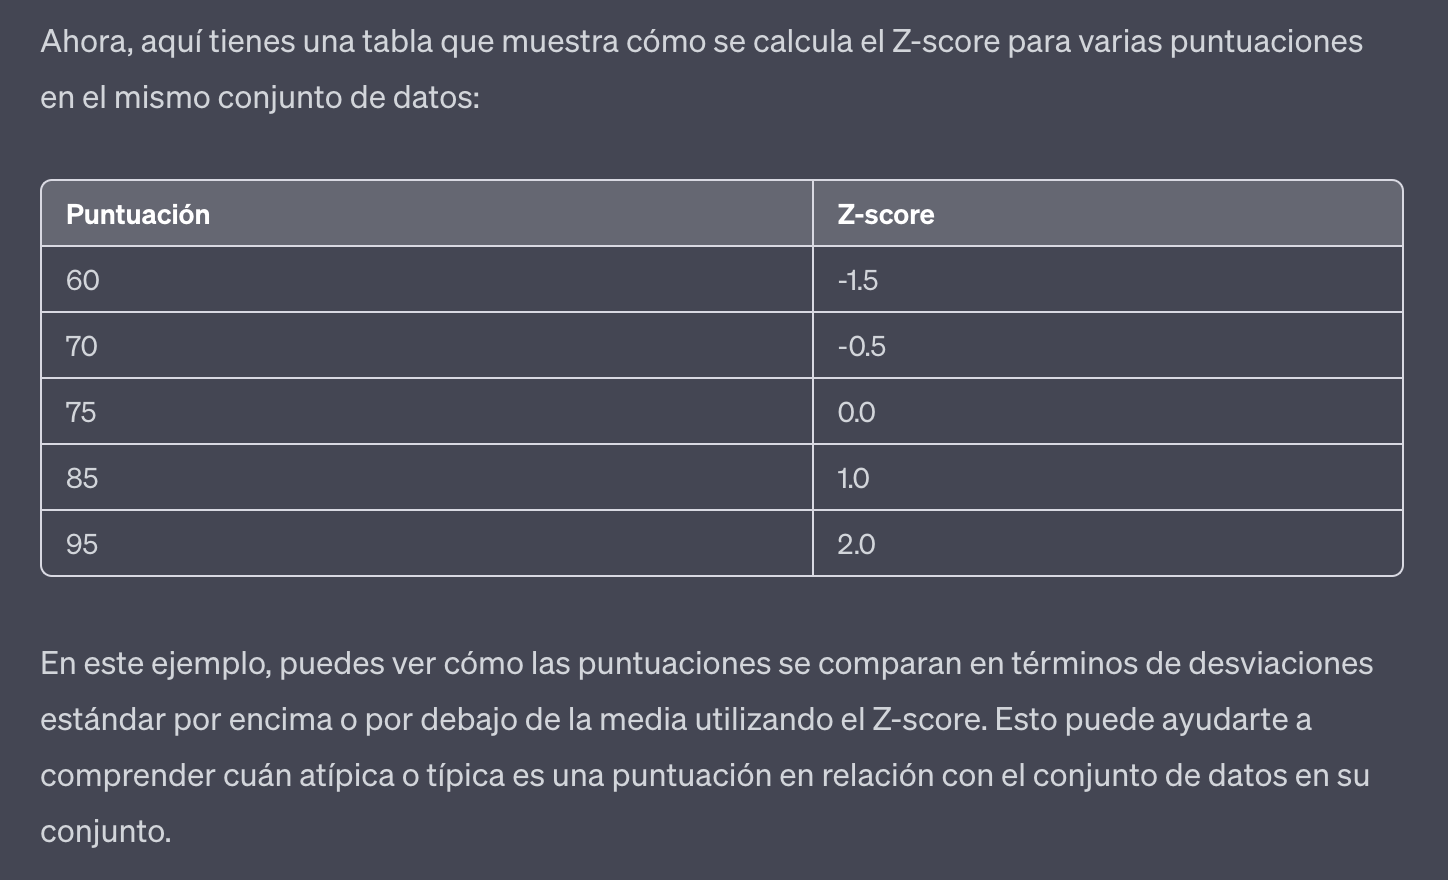

#### **Cómo calculamos la Desviación Estandar**

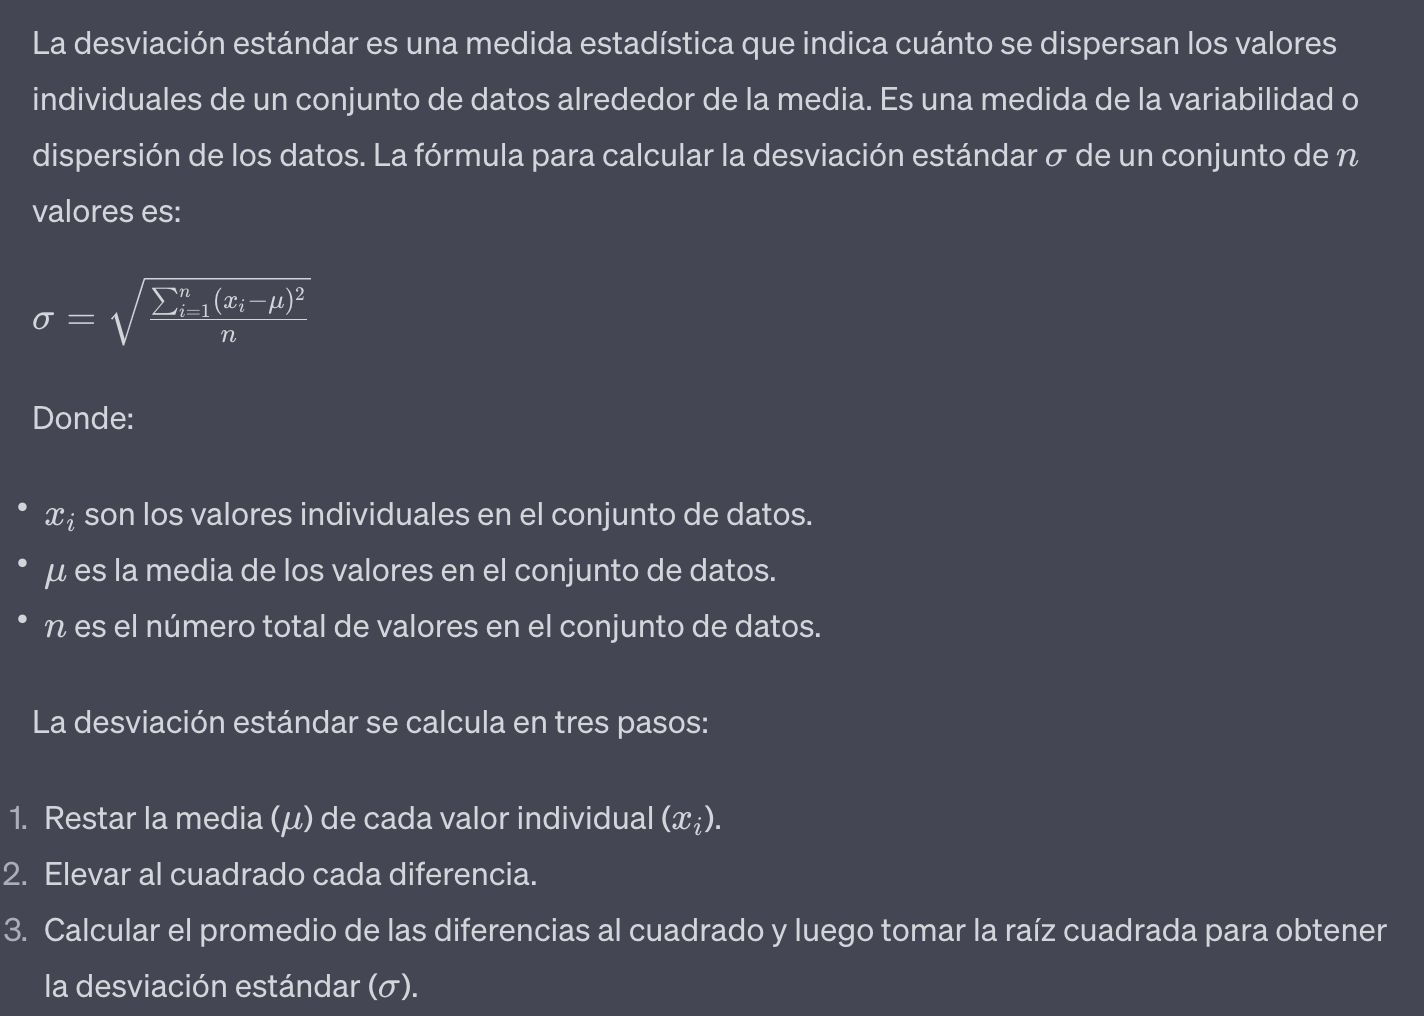

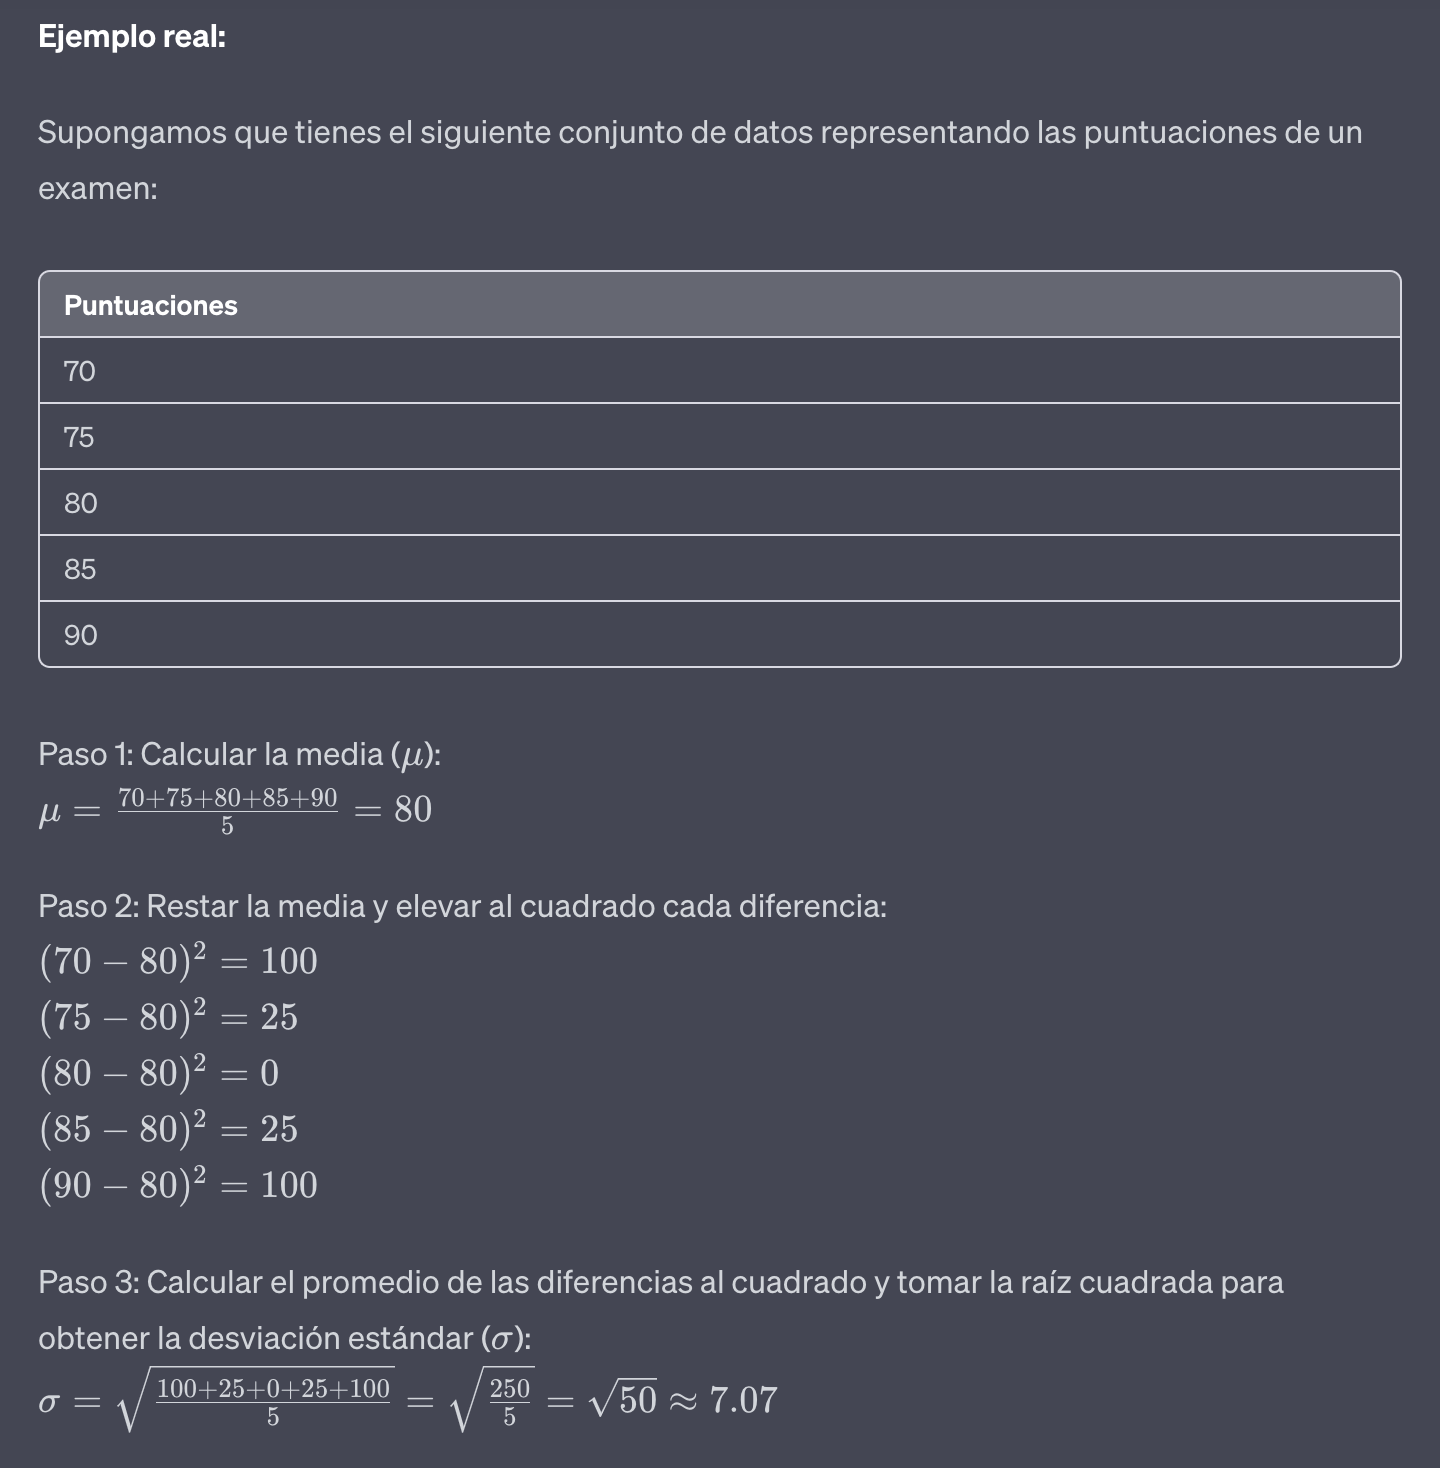

In [3]:
train_df.mean()

longitude              -119.6
latitude                 35.6
housing_median_age       28.6
total_rooms            2643.7
total_bedrooms          539.4
population             1429.6
households              501.2
median_income             3.9
median_house_value   207300.9
dtype: float64

In [4]:
train_df.std()

longitude                 2.0
latitude                  2.1
housing_median_age       12.6
total_rooms            2179.9
total_bedrooms          421.5
population             1147.9
households              384.5
median_income             1.9
median_house_value   115983.8
dtype: float64

In [5]:
#@title Calculamos el Z-score del `train_df` (del conjunto de entrenamiento)

# Calcular los Z-scores (puntuaciones Z) de cada columna
# en el conjunto de entrenamiento y escribir esos puntajes Z
# en un nuevo DataFrame de pandas llamado train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examinamos algunos de los valores del conjunto de entrenamiento
# normalizado. Tener en cuenta que la mayoría de los Z-scores
# puntuaciones Z se encuentran entre -2 y +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2879,0.9,-1.0,-1.6,1.8,1.8,0.3,1.0,0.5,2.1
3082,0.9,-0.9,-1.6,-0.1,-0.3,-0.2,-0.3,1.7,0.6
10386,-0.3,0.5,0.0,-0.5,-0.5,-0.0,-0.5,-0.8,-1.3
13193,-1.2,1.1,0.4,0.5,0.5,0.8,0.6,-0.2,-0.8
16700,-1.6,1.3,-0.3,0.2,0.1,0.2,0.1,0.1,0.3


In [9]:
#@title Calculamos el Z-score del `test_df` (del conjunto de prueba)

# Calcular los Z-scores (puntuaciones Z) de cada columna
# en el conjunto de prueba y escribir esos puntajes Z
# en un nuevo DataFrame de pandas llamado test_df_norm.
test_df_norm = (test_df - train_df_mean) / train_df_std

# Tenga en cuenta que transformamos los datos de prueba con los valores
# calculados a partir del conjunto de entrenamiento, ya que siempre debe
# transformar sus conjuntos de datos con exactamente los mismos valores.

## Tarea 1: Crear una etiqueta binaria

En los problemas de clasificación, la etiqueta para cada ejemplo debe ser 0 o 1. Desafortunadamente, la etiqueta natural en el conjunto de datos de vivienda de California, `median_house_value`, contiene valores de coma flotante como 80,100 o 85,700 en lugar de 0 y 1, mientras que la versión normalizada de `median_house_values` contiene valores de punto flotante principalmente entre -3 y +3.

Su tarea es crear una nueva columna llamada `median_house_value_is_high` tanto en el conjunto de entrenamiento como en el conjunto de prueba. Si `median_house_value` es más alto que cierto valor arbitrario (definido por `threshold`), establezca `median_house_value_is_high` en 1. De lo contrario, establezca `median_house_value_is_high` en 0.

**Sugerencia:** Las celdas en la columna `median_house_value_is_high` deben contener `1` y `0`, no `True` y `False`. Para convertir 'Verdadero' y 'Falso' a '1' y '0', llama a la función pandas DataFrame 'astype(float)'.

In [10]:
# Establecimos arbitrariamente el umbral en 265 000,
# que es el percentil 75 para los valores medios de las casas.
# Cada vecindario con un precio medio de vivienda superior
# a 265 000 se etiquetará con 1, y todos los demás vecindarios
# se etiquetarán con 0.
threshold = 265000 # This is the 75th percentile fo median house values.
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float)

# Imprima algunas celdas de ejemplo desde el principio y la mitad del conjunto
# de entrenamiento, solo para asegurarse de que su código creó solo 0 y 1

# en la columna median_house_value_is_high recién creada.
train_df_norm["median_house_value_is_high"].head(8000)

2879    1.0
3082    1.0
10386   0.0
13193   0.0
16700   0.0
         ..
15901   1.0
7464    0.0
15500   0.0
5459    0.0
11799   0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64